In [9]:
import numpy as np
import cv2
from skimage import exposure
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
from scipy.linalg import eigh
import numpy as np
from scipy.ndimage import gaussian_filter
import math
from numpy import linalg as LA

In [10]:
imsize = 400

# Load and resize the content image
content = cv2.imread("./images/house 2-small.jpg")
content = cv2.cvtColor(content, cv2.COLOR_BGR2RGB)

content_copy = content.copy()
content = content[0:imsize, 0:imsize]

# Load and resize the style image
style = cv2.imread("./images/starry-night - small.jpg")
style = cv2.cvtColor(style, cv2.COLOR_BGR2RGB)
style = style[0:imsize, 0:imsize]

(-0.5, 399.5, 399.5, -0.5)

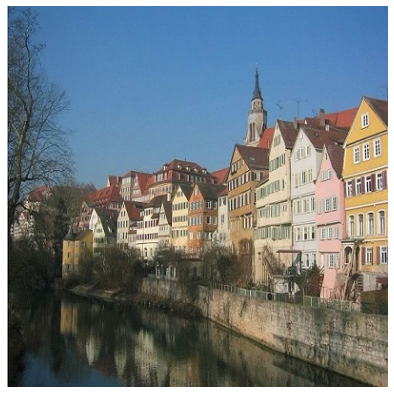

In [11]:
plt.figure(figsize=(15,7))
plt.imshow(content)
plt.axis("off")

(-0.5, 399.5, 399.5, -0.5)

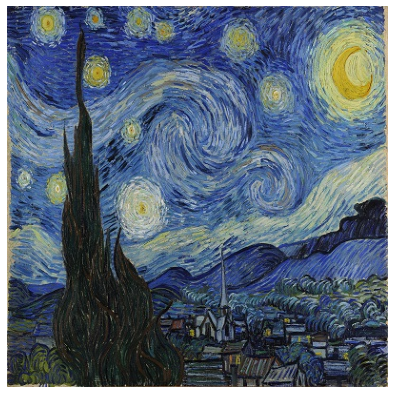

In [12]:
plt.figure(figsize=(15,7))
plt.imshow(style)
plt.axis("off")

In [13]:
import math

def nearest_n(R, X, Q_size, S, h, w, c, Pp, Vp, Pstride, mp, L, gap):

    S = S.reshape((h, w, c))
    RX = X[R.astype(bool)]

    print("RX Shape ", RX.shape)
    # RX Shape  (3888,)

    print("mp shape", mp.shape)
    # mp shape (3888,)

    print("Pp shape ", Pp.shape)
    # Pp shape  (512, 1156)

    print("Vp.T shape ", Vp.T.shape)
    # Vp.T shape  (512, 3888)

    RXp = np.dot(Vp.T, (RX - mp))
    print("Rxp shape ", RXp.shape)

    # RX Shape  (3888,)
    # mp shape (3888,)
    # Pp shape  (512, 1156)
    # Vp.T shape  (512, 3888)
    # Rx shape  (512,)

    # dif = np.tile(RXp, (1, Pp.shape[1])) - Pp
    # dif = np.tile(RXp.T, (Pp.shape[0], 1)) - Pp
    dif = np.tile(RXp[:, np.newaxis], (1, Pp.shape[1])) - Pp

    sqr = np.sum(dif**2, axis=0)
    # sqr = sqr + 0.1 * np.min(sqr) * np.random.randn(sqr.size)

    # idx = np.argmin(sqr)
    sqr = sqr + 0.1 * np.min(sqr) * np.random.randn(sqr.shape[0])  # Add some noise to 'sqr'
    idx = np.argmin(sqr)

    ls, ks = np.unravel_index(idx//4, ((w-Q_size+1-1)//Pstride+1, (h-Q_size+1-1)//Pstride+1)) #flipped since ind goes across rows, then down columns
    
    ks = (ks-1)*Pstride+1
    ls = (ls-1)*Pstride+1
    ang = (idx+3)%4 
    #+3 to match ang=90*(0:3)
    # Equivalent to mod(idx + 3, 4)

    print("RXp shape:", RXp.shape)
    print("Pp shape:", Pp.shape)
     
    # z = S[ks:ks+Q_size-1, ls:ls+Q_size-1, :]
    z = S[ks-1:ks+Q_size-1-1, ls-1:ls+Q_size-1-1,:] #maybe compute outside so no need to pass S
    z = z.reshape(-1)
     
    return ks, ls, z, ang
    # return 2


In [14]:

def style_transfer(content, style, hall, mask0, hallcoeff, Wcoeff, patch_sizes, scales, imsize):
    
    gap_sizes=[28 ,18 , 9, 6]
   
    # Smoothening the content image
    C0 = cv2.GaussianBlur(content, (5, 5), 100)

    # 2d image into 1d array
    C0 = content.reshape(-1)
    S0 = style.reshape(-1)

    h0 = imsize
    w0 = imsize
    # number of channels
    c = 3
    
    # Convert to 3D arrays only to use in histogram matching of color
    C0 = C0.reshape(h0, w0, c)
    S0 = S0.reshape(h0, w0, c)

    sigma_s = 5
    sigma_r = 0.2

    # COLOUR TRANSFER
    
    # The result of exposure.match_histograms is assigned back to C0[:, :, channel], 
    # effectively replacing the pixel values of the content image's specific color channel with 
    # new values that match the color distribution of the corresponding color channel in the style image.    

    for channel in range(c):
        C0[:, :, channel] = exposure.match_histograms(C0[:, :, channel], S0[:, :, channel])

    C0 = C0.reshape(-1)
    X = C0

    # INITIALISING OUTPUT IMAGE WITH NOISE - this is done to prevent repetitive patches 

    X = X + np.max(X) * np.random.randn(X.size)
    # X = X.reshape(h0, w0, c)

    X = X.reshape(-1)
    
    
    # Looping over scale sizes

    for L in scales:

        # here we first reshape into 3d array then scale down by factor of L. (0,0) is specified to determine size of output image 
        # It implies OpenCV should automatically calculate the size of the output image based on the provided scaling factors fx and fy

        C_scaled = cv2.resize(C0.reshape((h0, w0, c)), (0,0), fx=1/L, fy=1/L)
        S_scaled = cv2.resize(S0.reshape((h0, w0, c)), (0,0), fx=1/L, fy=1/L)

        # mask0 was the 400 x 400 array of 1s. We resize that as well

        mask = cv2.resize(mask0, (0,0), fx=1/L, fy=1/L)
        C = C_scaled.reshape(-1)
        S = S_scaled.reshape(-1)
        
        h = np.ceil(h0/L).astype(int)
        w = np.ceil(w0/L).astype(int)
      
        X = cv2.resize(X.reshape((h0, w0, c)), (0,0), fx=1/L, fy=1/L)

        # Halls is 400 x 400 x 3 array of 1s 
        halls = cv2.resize(hall, (0,0), fx=1/L, fy=1/L)

        X = X.reshape(-1)
        # print(X.shape)   # shape here is 30,000

        # we have obtained scaled version of content, style, hall and mask
        # now for each scale we define the patch size to reduce artifacts 
         
        for n in patch_sizes:

            Q_size = n
            
            # PRECOMPUTE P

            # this is the step size - number of pixels to be skipped when calculating patch information
            Pstride = 4

            S = S.reshape((h, w, c))

            # here basically we are creating a 3d array of zeroes of , and note that 
            # h-qize+1 is the number of starting points we can have along vertical direction 
            # w-qsize+1 is the number of starting points we can have along horizontal direction 
            # then to find total number of steps we divide by Pstride .

            numpatches =(int(((h - Q_size + 1) - 1) / Pstride) + 1) * (int(((w - Q_size + 1) - 1) / Pstride) + 1) 
            numpatches = numpatches * 4  # this is for all four rotations

            P = np.zeros((c * Q_size * Q_size, numpatches))

            # now we are trying to populate the P with the style image. We iterate the row using k and coloumn using j
            # skipping Pstride number of pixels each time

            for k in range(0, h - Q_size + 1, Pstride):
                for j in range(0, w - Q_size + 1, Pstride):

                    # extracting current patch
                    patch = S[k:k+Q_size, j:j+Q_size, :]

                    # Compare for each of the 4 orientations
                    for l in range(4):
                        temp = np.rot90(patch, k=l)
                        P[:, (int(k / Pstride) - 1) * (int((w - Q_size + 1 - 1) / Pstride) + 1) * 4 + (int(j / Pstride) - 1) * 4 + l + 1] = temp.flatten()
            
            S = S.reshape(-1)

            # Now P has been populated with style image patches
            # Remove mean from P
            
            # print("P matrix")
            # print(P)

            # print("P transpose")
            # print(P.T)

            # print(P.shape)    #(3888, 1156)
            # print(mp.shape)   #(3888,)

            #                          ------------------------------------------------------- COMPUTE PCA OF P----------------------------------------

            # PCA, or Principal Component Analysis, is a technique to simplify complex data. 
            # In style transfer, we used it to find the key artistic patterns in a style image. 
            # This is done by breaking down the image into simpler pieces called principal components. 
            # These components represent the essential artistic elements. We keep the essential components, while discarding those that don't carry important information about the patch.
            # Then, we picked the most important components based on their 'strength' (eigenvalues) to make the style transfer process more efficient and effective
             
            
            mp = np.mean(P, axis=1)
            # replicating mp dimension of P times and substracting from P
            P = P - np.tile(mp[:, np.newaxis], (1, P.shape[1]))
            
            
            # Computing eigenvectors (V) and eigenvalues (D) of the covariance matrix of P

            CoP = np.dot(P, P.T)
            # print(CoP.shape)     #3888 * 3888, symmetric matrix - checked

            D, V = np.linalg.eigh(CoP)
            sorted_indices = np.argsort(D)[::-1]
            
            # Sort eigenvalues and eigenvectors using the sorted indices
            D_sorted = D[sorted_indices]
            V_sorted = V[:, sorted_indices]
            
            # print("Original eigenvalues")
            # print(D)
            # print("sorted eigenvalues")
            # print(D_sorted)

            # print("Original eigenvectors")
            # print(V)

            # print("sorted eigenvectors")
            # print(V_sorted)

            # print("V shape: ", V.shape)        # (3888,3888)
            # print("V_sorted shape: ", V_sorted.shape)  # (3888,3888)
             
            eig_idx = 1
            energy = 0
            
            # To store cumulative energy
            total_energy = sum(D_sorted)

            for i in range(len(D_sorted)):
                energy += D_sorted[i]
                if energy >= 0.95 * total_energy:
                    eig_idx = i
                    break
            
            # Retain only upto eig_idx number of eiegnvectors

            Vp = V_sorted[:, :eig_idx]
            # print(Vp.shape)  # (3888, 512)

        
            Pp = np.dot(Vp.T, P)  
            # print(Pp.shape)   # 512 * 1556
            
            #     --------------------------------------------------CORRECT TILL HERE---------------------------------------
           
            # Iterate for k=1, ..., Ialg
            for k in range(3):
                
                # 1. Style Fusion
                X = hallcoeff * halls.reshape(-1) + (1 - hallcoeff) * X
                
                # 2. Patch Matching
                print('patch matching')
                gap = next(gap for gap, size in zip(gap_sizes, patch_sizes) if size == n)

                num_patch = (math.floor(((h - Q_size + 1) - 1) / gap) + 1) * (math.floor(((w - Q_size + 1) - 1) / gap) + 1)

                Rall = np.zeros((h * w * c, num_patch))
                z = np.zeros((c * n**2, num_patch))
                
                for i in range(0, h-Q_size+1, gap):
                    for j in range(0, w-Q_size+1, gap):
                        R = np.zeros((h, w, c))

                        R[i:i+Q_size, j:j+Q_size, :] = 1
                        R = R.reshape(-1)
                        
                        Rall[:, (math.ceil(i / gap) - 1) * (math.floor(((w - Q_size + 1) - 1) / gap) + 1) + math.ceil(j / gap)] = R
                        ks, ls, zij, ang = nearest_n(R, X, Q_size, S, h, w, c, Pp, Vp, Pstride, mp, L, gap)
                        
                        # k = nearest_n(R, X, Q_size, S, h, w, c, Pp, Vp, Pstride, mp, L, gap)
                        # temp = np.rot90(zij.reshape((n, n, c)), k=int(ang), axes=(0, 1))
                        # temp = cv2.resize(np.reshape(zij, (n, n, c)), None, fx=1, fy=1, interpolation=cv2.INTER_LINEAR)
                        # temp = cv2.rotate(temp, cv2.ROTATE_90_CLOCKWISE * ang)
                        # z[:, int((i/gap-1)*(np.floor((w-Q_size+1)-1)/gap) + np.ceil(j/gap))] = temp.reshape(-1)
                        
                return X

In [15]:
imsize = 400  

hall = style_transfer(
    content,
    style,
    np.ones((400, 400, 3)),
    np.ones((400, 400)),
    0,
    0,
    [36, 22],
    [4, 2, 1],
    imsize
)

patch matching
RX Shape  (3888,)
mp shape (3888,)
Pp shape  (512, 1156)
Vp.T shape  (512, 3888)
Rxp shape  (512,)
RXp shape: (512,)
Pp shape: (512, 1156)
RX Shape  (3888,)
mp shape (3888,)
Pp shape  (512, 1156)
Vp.T shape  (512, 3888)
Rxp shape  (512,)
RXp shape: (512,)
Pp shape: (512, 1156)
RX Shape  (3888,)
mp shape (3888,)
Pp shape  (512, 1156)
Vp.T shape  (512, 3888)
Rxp shape  (512,)
RXp shape: (512,)
Pp shape: (512, 1156)
RX Shape  (3888,)
mp shape (3888,)
Pp shape  (512, 1156)
Vp.T shape  (512, 3888)
Rxp shape  (512,)
RXp shape: (512,)
Pp shape: (512, 1156)
RX Shape  (3888,)
mp shape (3888,)
Pp shape  (512, 1156)
Vp.T shape  (512, 3888)
Rxp shape  (512,)
RXp shape: (512,)
Pp shape: (512, 1156)
RX Shape  (3888,)
mp shape (3888,)
Pp shape  (512, 1156)
Vp.T shape  (512, 3888)
Rxp shape  (512,)
RXp shape: (512,)
Pp shape: (512, 1156)
RX Shape  (3888,)
mp shape (3888,)
Pp shape  (512, 1156)
Vp.T shape  (512, 3888)
Rxp shape  (512,)
RXp shape: (512,)
Pp shape: (512, 1156)
RX Shape  (3